In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj 
from tqdm import tqdm
import reverse_geocoder as rg
from deap import base, creator, tools
import random

from shapely.geometry import Point
from shapely.geometry import LineString

from preprocessing.pre_process_stations import *
from preprocessing.pre_process_traffic import *
from preprocessing.helping_functions import *

from features.config import *
from features.financials_part_2 import *
from features.question_1 import *
from features.question_2 import *

from models.genetic_algorithm_part3_1 import *

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
class Config:
    PATH = '../../data/'

class Params:
    PARAM = 0
config = Config()
p = Params()

## Load data

In [11]:
def load_data():
    ##### Load new coordinates
    df_new_points = gpd.read_file(config.PATH+'new_coordinates/new_coordinates.shp')

    ##### Load hub data 
    df_hub_dense = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_denses.shp')
    df_hub_enlarged = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_elargies.shp')

    ##### Load traffic data
    df_traffic = gpd.read_file(config.PATH+'E-tmja2019-shp/TMJA2019.shp')
    df_traffic = preprocess_data(df_traffic)
    df_traffic = fix_tmja(df_traffic)

    df_new_points = distance_to_hub(df_hub_dense, df_hub_enlarged, df_new_points)

    df_traffic = df_traffic.groupby('route')[['TMJA_PL','percentage_traffic']].sum().reset_index(drop=False)
    df_new_points = df_new_points.merge(df_traffic, how='left', on='route')
    df_new_points = station_distances_all(df_new_points)

    data_region = gpd.read_file(config.PATH+'regions-20180101-shp/regions-20180101.shp')
    df_new_points = create_region_columns(df_new_points,data_region)

    return df_new_points

In [12]:
df_new_points = load_data()

Loading formatted geocoded file...


100%|██████████| 13978/13978 [03:28<00:00, 67.17it/s]


## Genetic algorithm deap library


In [16]:
stations_per_region = {'Region': ['Hauts-de-France','Bretagne','Île-de-France','Auvergne-Rhône-Alpes','Grand Est','Nouvelle-Aquitaine','Pays de la Loire','Occitanie','Centre-Val de Loire','Bourgogne-Franche-Comté','Normandie',"Provence-Alpes-Côte d'Azur"],
'Hydrogen Stations Needed 2030': [45,41,41,34,34,34,34,30,26,23,19,15],
'Hydrogen Stations Needed 2040': [267,245,245,200,200,200,200,178,156,134,111,89]}

In [17]:
nb_stations_per_region = pd.DataFrame(stations_per_region)
nb_stations_per_region

,Region,Hydrogen Stations Needed 2030,Hydrogen Stations Needed 2040
0,Hauts-de-France,45,267
1,Bretagne,41,245
2,Île-de-France,41,245
3,Auvergne-Rhône-Alpes,34,200
4,Grand Est,34,200
5,Nouvelle-Aquitaine,34,200
6,Pays de la Loire,34,200
7,Occitanie,30,178
8,Centre-Val de Loire,26,156
9,Bourgogne-Franche-Comté,23,134


### Per region

In [18]:
from deap import base, creator, tools
import random

In [19]:
region_name = 'Bretagne'

In [51]:
def genetic_algorithm(
        nb_stations,
        region_name,
        total_nb_stations,
        evaluate,
        num_generations,
        population_size,
        ):
    
    # Set up the DEAP toolbox
    creator.create("FitnessMax", base.Fitness, weights=[1.0,])
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()

    # Register the genetic operators
    toolbox.register("individual", tools.initRepeat, creator.Individual, lambda: np.random.choice(list(range(total_nb_stations)), size=nb_stations, replace=False),n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    # Create the initial population
    population = toolbox.population(n=population_size)

    # Evaluate the initial population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):        
        ind.fitness.values = fit

    # Set up the statistics objects to evaluate results
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)
    stats.register("argmin", np.argmin)

    avg_fitness = []
    min_fitness = []
    max_fitness = []
    arg_min_fitness = []

    # Start the evolution process
    for generation in tqdm(range(num_generations)):
    
        population = [x for x in population if type(x)!=int]

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if type(child1[0])==int:
                child1[0] = np.random.choice(list(range(total_nb_stations)), size=nb_stations, replace=False)
            elif type(child2[0])==int:
                child2[0] = np.random.choice(list(range(total_nb_stations)), size=nb_stations, replace=False)
            else:
                toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant)
            del mutant.fitness.values

        # Evaluate the new individuals
        fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, fresh_individuals)
        for ind, fit in zip(fresh_individuals, fitnesses):
            ind.fitness.values = fit

        # Add the new individuals to the population
        population[:] = offspring

        # Update the hall of fame and statistics
        record = stats.compile(population)
        avg_fitness.append(record["avg"])
        min_fitness.append(record["min"])
        max_fitness.append(record["max"])
        arg_min_fitness.append(record["argmin"])

    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

def run_ga(
        df_stations: gpd.GeoDataFrame,
        nb_stations_per_region: pd.DataFrame,
        region_name: str,
        year: int = 2030,
        num_generations: int = 30,
        population_size: int = 50):
    
    df_stations = sales(df_stations,year)
    
    df_stations_region = df_stations[df_stations[region_name]==True]
    
    nb_stations = nb_stations_per_region[nb_stations_per_region['Region']==region_name][f'Hydrogen Stations Needed {year}'].values[0]

    total_nb_stations = df_stations_region.shape[0]

    # Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
    def fitness(X,nb_stations=nb_stations,data: pd.DataFrame=df_stations_region):
        index = X[0]

        if type(index)==int:
            index = np.random.choice(list(range(data.shape[0])), size=nb_stations, replace=False)

        columns_distance = [c for c in data.columns if c.startswith('distance_to_point_')==True]
        if data.iloc[index,:].shape[0]>0:
            columns_distance_drop = [columns_distance[i] for i in index]
            data_sub = get_closer_station(data.iloc[index,:].drop(columns=columns_distance_drop))
            # constraint make sure the closest station is closer than 120km (for trucks with autonomy of 150km)
            data_sub = data_sub[data_sub['distance_closer_station'] < 120000]
            fit = 150 - (data_sub['distance_to_closest_large_hub'].mean() + data_sub['distance_to_closest_dense_hub'].mean())/10 + data_sub['distance_closer_station'].mean() + data_sub['Revenues_day'].mean()

        else:
            fit = -10e3
        
        return fit
    
    # Define the evaluation function
    def evaluate(individual):
        return fitness(individual),
    
    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = genetic_algorithm(
        nb_stations,
        region_name,
        total_nb_stations,
        evaluate,
        num_generations=num_generations,
        population_size=population_size
        )
    
    return region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness

In [ ]:
region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points,
        nb_stations_per_region,                                                          
        region_name=region_name,
        year = 2030,
        num_generations = 30,
        population_size = 50)

In [23]:
def plot_fitness_functions(avg_fitness):
    fig = plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(avg_fitness)),avg_fitness,label='mean')
    plt.xlabel('Generations')
    plt.ylabel('Average fitness function')
    plt.legend()
    plt.title('Evolution of fitness function')
    plt.show()

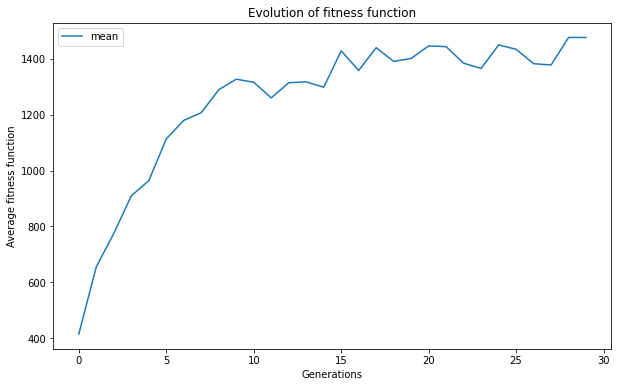

In [24]:
plot_fitness_functions(avg_fitness)

In [25]:
def extract_restults(
        population,
        max_fitness,
        df_stations
):
    best_gen = np.argmax(max_fitness)
    best_solution = population[best_gen][0]
    chosen_stations = pd.concat([df_stations.iloc[best_solution,:11],df_stations.iloc[best_solution,-2:]],axis=1)

    return chosen_stations

In [26]:
chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
)

chosen_stations_2030_per_reg = sales(chosen_stations_2030_per_reg, 2030)
chosen_stations_2030_per_reg = station_type(chosen_stations_2030_per_reg)
chosen_stations_2030_per_reg['Region'] = region_name

In [36]:
chosen_stations_2030_per_reg.head()

,index,easting,northing,route,geometry,closest_dense_hub,distance_to_closest_dense_hub,closest_elargie_hub,distance_to_closest_large_hub,TMJA_PL,percentage_traffic,Quantity_sold_per_day(in kg),Revenues_day,Quantity_sold_per_year(in kg),not_prof,small_station,medium_station,large_station,station_type,Region
296,296,670842.4759115779,6859116.178390036,A0004,POINT (670842.476 6859116.178),1.0,0 1405.055282 dtype: float64,5.0,0 0.0 dtype: float64,489209.44,0.039490,2578.483373,18049.383608,941146.431009,0,0,0,1,large,Bretagne
19,19,652120.8648179206,6866968.606225524,75000C01,POINT (652120.865 6866968.606),1.0,0 354.947188 dtype: float64,5.0,0 0.0 dtype: float64,0.00,0.000000,0.000000,0.000000,0.000000,1,0,0,0,not profitable,Bretagne
538,538,1048155.0540478148,6845895.819063297,A0004,POINT (1048155.054 6845895.819),1.0,0 1337.099909 dtype: float64,5.0,0 0.0 dtype: float64,489209.44,0.039490,2578.483373,18049.383608,941146.431009,0,0,0,1,large,Bretagne
8,8,847862.0769520273,6520701.477917263,69D0383,POINT (847862.077 6520701.478),1.0,0 172.756327 dtype: float64,5.0,0 0.0 dtype: float64,0.00,0.000000,0.000000,0.000000,0.000000,1,0,0,0,not profitable,Bretagne
611,611,773061.0275846705,6794953.429897669,A0005,POINT (773061.028 6794953.430),1.0,0 2893.642493 dtype: float64,5.0,0 2603.828671 dtype: float64,52949.71,0.004274,527.156425,3690.094976,192412.095187,0,0,0,1,large,Bretagne


In [38]:
list_regions = list(nb_stations_per_region['Region'].values)
#list_regions.remove('Bretagne')
#list_regions

['Hauts-de-France',
 'Île-de-France',
 'Auvergne-Rhône-Alpes',
 'Grand Est',
 'Nouvelle-Aquitaine',
 'Pays de la Loire',
 'Occitanie',
 'Centre-Val de Loire',
 'Bourgogne-Franche-Comté',
 'Normandie',
 "Provence-Alpes-Côte d'Azur"]

In [43]:
chosen_stations_2030_bretagne = chosen_stations_2030_per_reg

In [52]:
chosen_stations_2030 = chosen_stations_2030_bretagne

for region_name in list_regions:

    region_name,population,avg_fitness,min_fitness,max_fitness,arg_min_fitness = run_ga(df_new_points,
        nb_stations_per_region,                                                          
        region_name=region_name,
        year = 2030,
        num_generations = 30,
        population_size = 50)

    chosen_stations_2030_per_reg = extract_restults(
        population,
        max_fitness,
        df_new_points
    )

    chosen_stations_2030_per_reg = sales(chosen_stations_2030_per_reg, 2030)
    chosen_stations_2030_per_reg = station_type(chosen_stations_2030_per_reg)
    chosen_stations_2030_per_reg['Region'] = region_name

    chosen_stations_2030 = pd.concat([chosen_stations_2030,chosen_stations_2030_per_reg],axis=0)

chosen_stations_2030.to_csv('chosen_stations_2030.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

[1328   12 1154 1230 1327  378  417 1103  821 1134 1316  780  337  757
  453 1375   33 1302  333 1143  184  922  656  509  275 1362    6  819
  455 1173  252    7  958  854  843  633  168  845 1294 1147  720  878
  805 1326  282]
[ 888 1320  877  566 1014 1333  145 1063  391 1315  236  560  970 1181
  817 1130  993  652 1248  469   28   13  900  952 1058  389 1237  496
 1378  222 1117  995 1238  613  800  598 1375  140  278  443  119  948
  680    6  110]
[1328   12 1154 1230 1327  378  417 1103  821 1134 1316  780  337  757
  453 1375   33 1302  333 1143  184  922  656  509  275 1362    6  819
  455 1173  252    7  958  854  843  633  168  845 1294 1147  720  878
  805 1326  282]
[  36   73 1135  737  537 1227  799  110 1046  378  198  665  944  394
 1359  203  314 1152  601  310 1344  170 1229 1115   95 1184  739  391
  262 1259  684  338  384  346   61  133  844 1340  804 1113 1240  350
 1355  600  127]
[ 499 1167 1275  760 1105 1140 1040  848  273  322  432  534  910  274
  595  35

  3%|▎         | 1/30 [00:15<07:36, 15.73s/it]

[1138  981 1263  744  985  108  763  130  341  739 1162  479  539  620
  355  121 1095  757  840  973 1363  381 1293 1376 1341  505  322  334
  157  544  857 1334  725  486 1289 1133  380  793  492  582 1164 1172
  147 1272  512]
[ 268  957  165  431  284  238  300 1307  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101 1139  963 1035 1068 1113  439  837 1374  210  200 1139 1281
  127 1019 1204]
[ 268  957  165  431  284  238  300 1307  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  951 1290 1374  210  200 1139 1281
  127 1019 1204]
[1297  490  509 1310  720 1363  366  975  650  423 1300 1167  357  174
  324  633  361  663  449 1079  555  286  874  605  723   22 1009  952
   84  735 1121  802  807  955  614  704  439  791  708 1173 1294  199
 1249 1236  502]
[ 810  690 1341  327  156 1101 1116  777 1141   60  608 1236   39    1
  416  58

  7%|▋         | 2/30 [00:35<08:29, 18.19s/it]

[   9  554 1214 1252  328  504  300 1307  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116 1022 1326  661 1217
  668  858  462]
[ 810  690  509 1310  720 1363  366  975  650  423 1300 1167  357  174
  324  633  361  663  449 1079  555  286  874  605  723   22 1009  952
   84  735 1121  802  807 1189 1344 1170  996   26  344 1381  294  331
 1239  905 1055]
[1045  228 1292 1002  328  504  300 1307  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116 1022  113  958   28
 1242  533 1063]
[ 268  957  165  431  284  238  300 1307  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101 1139  963 1035 1068 1113  439  837 1374  210  200 1139 1281
  127 1019 1204]
[1297  490  509 1310  720 1363  366  975  650  423 1300 1167  357  174
  324  63

 10%|█         | 3/30 [00:47<06:48, 15.13s/it]

[1297  490  509 1310  720 1363  366  975  650  423 1300 1167  357  174
  324  633  361  663  449 1079  555  286  874  605  723   22 1009  952
   84  735 1121  802  807  955  614  704  439  791  708 1173 1294  199
 1249 1236  502]
[1328   12 1154 1230 1327  378  417 1103  821 1134 1316  780  337  757
  453 1375   33 1302  333 1143  184  922  656  509 1058  389 1237  496
 1378  222 1117  995 1238  613  800  598 1375  140  278  443  720  878
  805 1326  282]
[   9  554 1214 1252 1211  842  524  459  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  286  874  605  723   22 1009  952
   84  735 1121  802  807  955  614  704  439  791  708 1326  661 1217
  668  858  462]
[1297  490  509 1310  720 1363  366  975  650  423 1300 1167  357  174
  324  633  361  663  449 1079  555  286  874  605  723   22 1009  952
   84  735 1121  802  807  955  614  704  439  791  708 1173 1294  199
 1249 1236  502]
[   9  554 1214 1252 1211  842  524  459  291   35 1369   64  357  174
  324  63

 13%|█▎        | 4/30 [01:07<07:28, 17.25s/it]

[1138  981 1263  461  131 1212  545  518   81  296 1133  983  292 1129
  486  504  202  438  939  673 1299  120   38  364 1233  470  513  444
  602  673  542 1337 1156  717  884  416   22  343 1025  324  695  631
  670 1272  512]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409 1093  857  595  755  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116 1022  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956  975  650  423 1300 1167  357  174
  324  633  361  663  449 1079  555  733  409 1093  857  595  755  663
  594  228  347  163 1118 1278 1078 1177   39 1089  597  188 1169   80
   68  721  165]
[1297  957  165  431  284  238  300 1307  211   35 1369   64  357  174
  324  63

 17%|█▋        | 5/30 [01:26<07:23, 17.75s/it]

[1143  662  528  200 1174 1101 1116  777 1141   60  608 1236 1319  227
  324  633  361  663  449 1079  555  286  874  376   40  329 1110  579
    0 1101  501  163 1118 1278 1078 1177   39 1089  597  188 1169   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116  597  188 1169   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409 1093  857  595  755  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409 1093  857  595  755  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1138  981 1263  461  131 1212  545  518   81  296 1133  983  292 1129
  486   1

 20%|██        | 6/30 [01:39<06:29, 16.23s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116 1022  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409 1093  857  595  755  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1138  981 1263 1310  720 1363  366  975  650  423 1300 1167  357  174
  324  633  361  663  449 1079 1299  120   38  364 1233  470  513  444
  602  673  542  231  624  717  884  416   22  343 1025  324  695  631
  670 1272  512]
[1143  662  528  200 1174  982  956 1244  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  542  231  624  717  884 1177   39 1089  597  188 1169   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  63

 23%|██▎       | 7/30 [01:50<05:34, 14.52s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116 1022  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  579
  602  673  542 1337 1156  717  884  416   22  343 1025  188 1169   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116  597  188 1169   80
   68  721  165]
[1045  228  165  431  284  238  300 1244  291   35 1300 1167  357  174
  324   11  218  855   41  794  629  949 1024  376   40  329 1110  579
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721 1063]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  63

 27%|██▋       | 8/30 [02:01<04:52, 13.29s/it]

[1045  228  165  431  284  238  300 1244  291   35 1300 1167  357  174
  324   11  218  855   41  794  629  949 1024  376   40  329 1110  579
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721 1063]
[1143  662  528  200 1174  982  956  518   81  296 1133  983  292 1129
  486   11  218  855   41  673 1299  120  409 1093   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  211 1157 1087  928 1319  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  542  231  624  717  884 1177   39 1089  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956  518   81  296 1300 1167  357  174
 1004   1

 30%|███       | 9/30 [02:12<04:24, 12.62s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409 1093   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654  273  116 1022  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  542  231  624  717 1097  654  273  116  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  63

 33%|███▎      | 10/30 [02:24<04:06, 12.33s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  579
    0 1101  347  163  624  602 1097  654  273  116 1022  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324  633  361  663  449 1079  555  733  409 1093   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  579
    0 1101  542  231  624  717 1097  654  273  116  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  579
    0 1101  542  231  624  717 1097  654  273  116  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 37%|███▋      | 11/30 [02:34<03:43, 11.77s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324   11   33 1302   41  794  629  949 1024  376 1233  329 1110  579
    0 1101  501  231  624  602 1097  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  629  949 1024  376   40  329 1110  579
    0 1101  542  231  624 1278 1097  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324   11   33 1302   41  794  629  949 1024  376 1233  470  513  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  174
  324   11   33 1302   41  794  629  949 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 40%|████      | 12/30 [02:45<03:25, 11.44s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  116  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 43%|████▎     | 13/30 [02:55<03:10, 11.22s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  794  555  286  874  605   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 47%|████▋     | 14/30 [03:09<03:10, 11.92s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33 1302   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594 1101  501  231  624  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 50%|█████     | 15/30 [03:20<02:56, 11.78s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  794  555  286  874  605   40  329 1110  663
  594  228  347  163 1118 1278 1078  416   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594 1101  501  231  624  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594 1101  501  231  624  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 53%|█████▎    | 16/30 [03:32<02:43, 11.70s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 57%|█████▋    | 17/30 [03:43<02:31, 11.65s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  113  958   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 60%|██████    | 18/30 [03:55<02:19, 11.61s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  794  555  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343 1025  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 63%|██████▎   | 19/30 [04:10<02:19, 12.67s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  501  231  624  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  376   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 67%|██████▋   | 20/30 [04:22<02:04, 12.45s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  120 1024  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 70%|███████   | 21/30 [04:35<01:52, 12.52s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286 1024  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11  218  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 73%|███████▎  | 22/30 [04:45<01:35, 11.91s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 77%|███████▋  | 23/30 [04:56<01:20, 11.53s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 80%|████████  | 24/30 [05:10<01:12, 12.17s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 83%|████████▎ | 25/30 [05:31<01:15, 15.10s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 87%|████████▋ | 26/30 [05:43<00:56, 14.08s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  579
    0 1101  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 90%|█████████ | 27/30 [05:55<00:40, 13.35s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 93%|█████████▎| 28/30 [06:07<00:26, 13.13s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

 97%|█████████▋| 29/30 [06:20<00:12, 12.85s/it]

[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   11   33  855   41  673 1299  286  874  605   40  329 1110  663
  594  228  347  163 1118  602 1097  654   22  343  597  324  695   80
   68  721  165]
[1143  662  528  200 1174  982  956 1244  291   35 1369   64  357  227
 1004   1

  0%|          | 0/30 [00:00<?, ?it/s]

[ 875  377   52  954  265  429  848  130  499 1041   99  484  624  579
   81  476 1034  654 1037  821  704  248  511   63  230  179  543  917
  951  172  778  969  256  328  127  286  173  444  682  184  226]
[ 439  514  817  562   95  195  845  321 1009  907  378  305  989  681
   10  703  256  395  131  245   44  127  340  619  993 1039  211   15
   90  117  768  677  273  509  363  289  726  858  390  224  119]
[ 412  574  215  886  398  504  169  117  234 1021  192  775  303  742
  177  841  939  132  945  272  591  107    5  468  551  863    9  434
  201  735  674  895  839  957  910  585   82  525  256  204 1057]
[ 286  178  606  399  339  162   88  774  386  947  494   99  310  702
  901  271  485  200  723  380  126  421  839  449  486   36  190  157
  796  484  245  500  838  373  520  506  993 1028  566  660  253]
[ 266  171  758  792  766   91  249  630  339  357  847  829  613  271
  711  713   31  635  395  649  554  282  331  599  487  153  379  179
  363  565  264 1007  

  3%|▎         | 1/30 [00:12<06:13, 12.87s/it]

[ 592  183   33  504  264  184  740   54  669  515  825  236  133  702
  223  404  253  596  259  413  107  779  880 1002  961  187  148  283
  526 1012  826  411  556  320  323  234  812  147  955   63  852]
[ 592  183   33  504  264  184  740   54  669  515  825  236  133  702
  223  404  253  596  259  413  107  779  880 1002  961  187  148  283
  526 1012  907  466  308  859  667  374  812  147  955   63  852]
[ 875  377  701 1032  662  844 1025   67  584  301  119  922  475  663
  225  918  427  136  295  836  813  618  656  419    8  233  872  694
 1004  751  907  466  308  859  667  374  755  109  937  255   21]
[ 581  736  379  981  415  815  675   73   63  555   72  441  104  249
  583  171  215  397  325  298  936  923  310  411  423 1054    1  316
  189 1012  826  411  556  320  323  256  993  952  585  341 1006]
[ 439  514  817  562   95  195  845  316  593  907  378  305  989  681
   10  703  256  395  131  245   44  127  340  619  993 1039  211   15
   90  117  768  677  

  7%|▋         | 2/30 [00:24<05:33, 11.92s/it]

[ 581  736  379  981  415  815  675   73   63  555   72  441  104  249
  583   62  580  927  714  298  936  923  310  411  423 1054    1  316
  189 1012  826  411  556  320  323  256  993  952  585  341 1006]
[ 209    3  701 1032  339  162   88  774  386  301  119  922  475  663
  225  918  427  136  295  836  813  618  656  419    8  233  872  694
 1004  751  907  466  308  859  667  374  755  109  937  255   21]
[ 197  845  465  164  814  780  868  816  794  597  560  795  619  426
  315   62  580  927  714  676 1038  544  808  536  744   92  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  650]
[ 439  514  817  562   95  195  845  316  593  907  378  305  989  681
   10  703  256  395  131  245   44  127  340  619  993 1039  211   15
   90  122  768  677  273  509  363  289  726  858  390  224  119]
[ 276  111  559  257   98   57  754  483   26  887  543  137  818  936
  574  830   58  463   59  112  756    9  627  280  825  316  884  232
  195  120  336   80  

 10%|█         | 3/30 [00:36<05:30, 12.25s/it]

[353  55 407 589  81 249 675  73  63 555  72 441 104 249 583 171 215 397
 325 298 936 923 310 530 943 828 738 845 430 122 693 840 989 113  96 590
 764 877 746 168 297]
[ 581  736  379  221  858  265  740   54  669  515  825  236  133  547
  189  980  377  824  694  601  626  411  895  450  184  918  298  476
  335  503   20  323  490  796  323  256  993  952  585  341 1006]
[ 286  178  606  399  339  162   88  774  386  947  494   99  310  702
  901  271  485  200  723  380  126  421  839  449  486   36  190  157
  796  484  245  500  838  373  520  506  993 1028  566  660  253]
[ 875  377  701 1032  662  844 1025   67  584  301   72  441  104  249
  583  171  215  397  325  298  936  923  310  411  423 1054    1  316
  189  799  536  126  976  794  726  256  993  952  585  341   21]
[ 197  845  465  164  814  780  868  816  794  597  560  795  619  426
  315   62  580  927  714  676 1038  544  808  536  744   92  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  6

 13%|█▎        | 4/30 [00:49<05:22, 12.41s/it]

[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  223  404  253  596  259  413  107  779  895  450  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[ 581  736  379  221  858  265  675   73   63  555   72  441  104  249
  583  171  215  397  325  298  936  923  310  411  423  918  298  476
  335  503   20  323  490  796  323  256  993  952  585  341 1006]
[ 197  845  465  164  814  780  868  816  794  515  825  236  133  547
  189  980  377  824  694  676 1038  544  808  536  744   92  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  650]
[ 439  514  817  562  662  844 1025   67  584  301  119  441  104  249
  583  171  215  397  325  298  936  923  310  411    8  233  872  694
 1004  751  907  466  308  859  667  708   73  861   98  391  119]
[ 581   55  407  589   81  249  675   73   63  555   72  441  104  249
  583  171  215  397  325  298  936  923  310  411  423 1054    1  316
  189  799  536  126  

 17%|█▋        | 5/30 [01:01<05:10, 12.43s/it]

[ 581  736  379  221  858  265  675   73   63  555   72  441  104  249
  583  980  377  824  694  601  626  411  895  450  184  918  298  476
  335  503   20  323  490  796  323  256  993  952  585  341 1006]
[581  55 407 589  81 249 675  73  63 555  72 441 104 249 583 171 215 397
 325 298 936 923 310 411   8 233   1 316 189 799 536 126 490 796 163 189
 879 151  98 391 119]
[ 581  736  379  221  858  265  675   73   63  555   72  441  104  249
  583  980  377  824  694  601  626  411  895  450  184  918  298  476
  335  503   20  323  490  796  323  256  993  952  585  341 1006]
[857 493 438 164 858 265 740  54 669 515 825 236 133 702 223 404 253 596
 259 413 107 779 895 450 184 918 298 476 335 503  20 323 490 796 163 189
 879 861 873 146 798]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  223  404  253  596  259  413  107  779  895  450  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[ 581  736  379  221  858  265  675  

 20%|██        | 6/30 [01:13<04:47, 11.99s/it]

[ 581  736  379  221  858  265  675   73   63  555   72  441  104  249
  583  171  215  397  325  413  107  779  895  450  184  918  298  476
  335  503   20  323  490  796  163  256  993  952  585  341 1006]
[ 197  845  465  164  814  780  868  816  794  515  825  236  133  547
  189  980  377  824  694  676 1038  544  808  536  744   92  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  650]
[439 514 817 164 814 780 868 816 584 515 825 236 133 702 223 404 253 596
 259 413 107 779 895 450 184 918 298 476 335 503  20 323 490 796 163 189
 879 151  98 391 119]
[ 581  736  379  221  858  265  675   73   63  555   72  441  104  249
  583  171  215  397  325  298  936  923  310  411  423  918  298  476
  335  503   20  323  490  796  323  256  993  952  585  341 1006]
[439 514 817 221 858 265 675  73  63 555  72 441 104 249 583 171 215 397
 325 298 936 923 310 411   8 233   1 316 189 799 907 466 308 859 667 708
  73 151  98 391 119]
[ 439  514  817  562  662  844 1025  

 23%|██▎       | 7/30 [01:24<04:28, 11.68s/it]

[439 514 817 164 814 780 868 816 584 515 825 236 133 702 223 404 253 596
 259 413 107 779 895 450 184 918 298 476 335 503  20 323 490 796 163 189
 879 151  98 391 119]
[439 514 817 164 814 780 868 816 584 515 825 236 133 702 223 980 377 824
 694 676 936 923 310 411 423 918 298 476 335 503  20 323 490 796 163 189
 879 151  98 391 119]
[439 514 817 221  81 249 675  73  63 555  72 441 104 249 583 171 215 397
 325 298 936 923 310 411   8 233   1 316 189 799 536 126 490 796 163 189
 879 151  98 391 119]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  895  450  184   92  861  307
  480  501   20  323  490  796  163  189  879  151   98  391  119]
[ 197  845  465  164  814  780  868  816  794  515  825  236  133  547
  189  980  377  824  694  676 1038  544  808  536  744   92  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  650]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  583  

 27%|██▋       | 8/30 [01:35<04:12, 11.49s/it]

[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  895  450  184   92  861  307
  480  501   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  895  450  184   92  861  307
  480  501   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  589   81  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  923  310  411  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  923  310  411  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  223  404  253  397  325  298  936  923  310  530  943  828  738  316
  189  799  907  466  

 30%|███       | 9/30 [01:46<03:59, 11.38s/it]

[ 439  514  817  589   81  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  923  310  411  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  562  662  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  480  501   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  589   81  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  923  310  411  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[ 439  514  817  589   81  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  923  310  411  184  918  298  476
  335  503   20  323  490  796  163  189  879  151   98  391  119]
[439 514 817 164 814 780 868 816 584 515 825 236 133 702 223 404 253 596
 259 413 107 779 895 450 184 918 298 476 335 799 536 126 490 796 163 189
 879 151  98 391 1

 33%|███▎      | 10/30 [01:57<03:45, 11.26s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 895 450 184  92 861 307 480 501  20 323 490 796 163 189
 879 151  98 391 119]
[ 197  845  465  164  814  780 1025   67  584  515  825  236  133  702
  223  404  253  397  325  298  936  923  310  530  943  828  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  650]
[439 514 817 562 814 780 868 816 584 515 825 236 133 702 583 171 215 397
 325 298 936 779 895 450 184  92 861 307 480 501  20 323 490 796 163 189
 879 151  98 391 119]
[197 845 465 164 814 780 868 816 584 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 738 316 189 799 907 466 308 859 667 708
  73 151  98 391 650]
[197 845 465 164 814 780 868 816 794 515  72 441 104 249 583 171 215 397
 325 298 936 923 310 411 184 918 298 476 335 503  20 323 490 796 163 189
 879 151  98 391 650]
[439 845 465 164 814 780 868 816 584 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 738 316 189 7

 37%|███▋      | 11/30 [02:08<03:34, 11.29s/it]

[439 514 817 164 814 780 868  67 584 515 825 236 133 702 583 171 215 397
 325 298 936 923 310 530 943 828 738 316 189 799 907 466 308 859 667 708
  73 151  98 391 119]
[439 514 817 164 814 780 868 816 794 515 825 236 133 702 223 171 215 397
 325 413 107 779 895 450 184 918 298 476 335 799 907 323 490 796 163 189
 879 151  98 391 119]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501  20 323 490 796 163 189
 879 151  98 391 119]
[439 514 817 164 814 780 868  67 584 515 825 236 133 702 583 171 215 397
 325 298 936 923 310 530 943 828 738 316 189 799 907 466 308 859 667 708
  73 151  98 391 119]
[ 197  845  465  164  814  780 1025   67  584  515  825  236  133  702
  223  404  253  397  325  298  936  923  310  530  943  828  861  307
  480  501  516  918  672  944   69  708   73  151   98  391  650]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  895  4

 40%|████      | 12/30 [02:19<03:21, 11.19s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 895 450 184  92 861 307 480 501  20 323 490 796 163 189
 879 151  98 391 119]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  895  450  184   92  861  307
  335  503  516  918  672  944  163  189   73  151   98  391  650]
[439 514 817 164 814 780 868  67 584 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 943 828 738 316 189 799 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 780 868 816 584 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 738 316 189 799 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 780 868 816 584 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 738 316 189 799 907 466 308 859 667 708
  73 151  98 391 119]
[197 845 465 164 814 844 868 816 794 515 825 236 133 547 223 404 253 596
 259 413 107 779 895 450 184 918 298 476 335 7

 43%|████▎     | 13/30 [02:31<03:11, 11.26s/it]

[197 845 465 164 814 844 868 816 584 515 825 236 133 702 583 171 215 397
 325 298 936 779 895 450 184  92 861 307 335 503 516 918 672 944 163 189
  73 151  98 391 650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[197 845 465 164 814 844 868 816 584 515 825 236 133 702 583 171 215 397
 325 298 936 779 895 450 184  92 861 307 335 503 516 918 672 944 163 189
  73 151  98 391 650]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  480  501  516  9

 47%|████▋     | 14/30 [02:45<03:13, 12.10s/it]

[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  335  799  516  918  672  796  163  189   73  151   98  391  650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 779 310 530 184 918 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  4

 50%|█████     | 15/30 [03:01<03:20, 13.36s/it]

[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  335  799  516  918  672  796  163  189   73  151   98  391  650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  335  799  907  323  490  796  163  189   73  151   98  391  650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 

 53%|█████▎    | 16/30 [03:16<03:15, 13.95s/it]

[197 845 465 164 814 844 868  67 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 466 308 859 667 708
  73 151  98 391 650]
[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  335  799  907  323  490  796  163  189   73  151   98  391  650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 335 5

 57%|█████▋    | 17/30 [03:28<02:52, 13.24s/it]

[ 197  845  465  164  814  844 1025   67  584  515  825  236  133  702
  583  171  215  397  325  298  936  779  310  411  184  918  298  476
  335  799  907  323  490  796  163  189   73  151   98  391  650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 307 480 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 335 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 335 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 501 907 466 308 859 667 708
  73 151  98 391 119]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 335 5

 60%|██████    | 18/30 [03:39<02:32, 12.73s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 335 501 907 466 308 859 667 708
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 323 490 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 702 223 404 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 323 490 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 215 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 323 490 796 163 189
  73 151  98 391 650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 501 907 466 308 859 667 708
  73 151  98 3

 63%|██████▎   | 19/30 [03:51<02:15, 12.35s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 779 310 411 184 918 298 476 335 501 907 466 308 859 667 708
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 223 404 215 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 323 490 796 163 189
  73 151  98 391 119]
[197 845 465 164 814 844 868  67 794 515 825 236 133 547 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 584 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 3

 67%|██████▋   | 20/30 [04:02<02:01, 12.11s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 323 490 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[439 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 490 859 667 708
  73 151  98 391 119]
[197 845 465 164 814 844 868  67 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 943 828 861 307 480 501 907 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 335 799 907 323 490 796 163 189
  73 151  98 3

 70%|███████   | 21/30 [04:14<01:47, 11.90s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 3

 73%|███████▎  | 22/30 [04:27<01:37, 12.18s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 501 907 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 501 907 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 779 310 411 184 918 298 476 335 799 907 323 490 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 3

 77%|███████▋  | 23/30 [04:39<01:25, 12.22s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868  67 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 3

 80%|████████  | 24/30 [04:52<01:14, 12.41s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 501 907 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 3

 83%|████████▎ | 25/30 [05:04<01:01, 12.33s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 923 310 530 184 918 298 476 480 501 516 918 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 3

 87%|████████▋ | 26/30 [05:16<00:49, 12.37s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 3

 90%|█████████ | 27/30 [05:28<00:36, 12.30s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 779 310 411 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 3

 93%|█████████▎| 28/30 [05:41<00:25, 12.51s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 171 253 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 335 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 3

 97%|█████████▋| 29/30 [05:56<00:13, 13.21s/it]

[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 391 650]
[197 845 465 164 814 844 868 816 794 515 825 236 133 702 583 404 215 397
 325 298 936 923 310 530 184 828 298 476 480 799 907 323 672 796 163 189
  73 151  98 3

In [25]:
finance_chosen_stations_2030 = financial_summary(chosen_stations_2030)

In [26]:
finance_chosen_stations_2030

station_type,large,not profitable
CAPEX,-2.010128e+09,0.0
EBIT,4.174722e+08,0.0
EBITDA,7.709022e+08,0.0
Opex,7.497000e+07,0.0
Revenues,8.458722e+08,0.0
depreciation,3.534300e+08,0.0
Total,4.525189e+08,0.0


## Part 2.2

- done !

## Part 3.3

- add distance to all total stations and add it to fitness function to maximise it
- focus on a niche total is not very present and where traffic is quite high --> conventional for production but more risky for profitability
